In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

In [2]:
ml_models_path = "ml_models/"
number_models = 0

for file in os.listdir(ml_models_path):
    if(file.startswith("sl_")):
        number_models += 1

In [3]:
fpi_results = pd.DataFrame()

for i in range(number_models):
    model_fpi_results_path = f"{ml_models_path}sl_{i}/model_fpi_results_df"
    model_fpi_results = pd.read_csv(model_fpi_results_path)

    # "Feature" column has comma-separated strings that can be in different orders
    # Alphabetize the comma-separated strings
    delimiter = ","
    
    for row in range(len(model_fpi_results)):
        feature = model_fpi_results.loc[row, "Feature"]
        alphabetized_feature = delimiter.join(sorted(feature.split(delimiter), key=str.casefold))
        model_fpi_results.loc[row, "Feature"] = alphabetized_feature
        
    if i == 0:
        fpi_results = model_fpi_results
    else:
        fpi_results = pd.concat([fpi_results, model_fpi_results])

fpi_results = fpi_results.groupby(["Feature"]).mean()

fpi_results

,Avg_Ratioknn-uni0,Std_Ratioknn-uni0,Avg_Ratioknn-dist0,Std_Ratioknn-dist0,Avg_Ratioxgb0,Std_Ratioxgb0,Avg_Rationusvr-lin0,Std_Rationusvr-lin0,Avg_Rationusvr-rbf0,Std_Rationusvr-rbf0,Avg_Ratiopls0,Std_Ratiopls0,Avg_Ratioetr0,Std_Ratioetr0,Avg_Rationusvr-poly0,Std_Rationusvr-poly0,Avg_Ratiolasso0,Std_Ratiolasso0
Feature,,,,,,,,,,,,,,,,,,
"Mean_DO_mg_per_L,Mean_DO_percent_saturation",1.485365,0.076011,1.912577,0.058827,1.468507,4.300556e-02,1.030752,0.013144,2.734595,0.127508,1.045919,0.015554,1.005370,7.023577e-04,1.164080,0.022506,11.419145,1.164788
"crp_pc_cse,ele_mt_cav,for_pc_cse,gwt_cm_cav,ire_pc_cse,Mean_Temp_Deg_C,slp_dg_cav,tmp_dc_cyr",6.207475,0.323526,5.590600,0.222244,3.834351,1.612807e-01,1.401449,0.031754,4.563347,0.147619,1.344256,0.033231,1.274580,2.534413e-02,1.232303,0.032978,24.672125,1.440891
"dor_pc_pva,RA_dm,RA_ms_av,RA_ms_di,RA_SO",4.070282,0.244684,3.939947,0.163411,2.186922,8.225902e-02,1.331354,0.038388,3.445486,0.127464,1.435290,0.048423,1.011703,1.137638e-03,1.375008,0.034821,19.031910,2.128570
gla_pc_cse,1.003992,0.002291,1.010688,0.013034,1.000000,8.006920e-08,1.001202,0.000822,1.021543,0.020634,1.009491,0.007028,1.000000,1.578952e-16,1.021031,0.009072,1.008101,0.004537
pH,1.387452,0.099255,2.198941,0.088284,1.132787,2.255821e-02,1.071266,0.015035,1.876717,0.084405,1.034920,0.011714,1.005304,1.301775e-03,1.002333,0.003394,3.779978,0.229426
ppd_pk_cav,1.030613,0.012342,1.312721,0.043403,1.119878,2.213235e-02,1.055676,0.011387,1.466155,0.052245,1.132813,0.023398,1.000503,8.190842e-05,1.075307,0.016924,6.381271,0.643739
"pre_mm_cdi,pre_mm_cyr,pst_pc_cse,run_mm_cyr,tmp_dc_cdi",3.376402,0.245332,3.841653,0.156103,1.904324,6.601945e-02,1.132773,0.019576,3.680691,0.135095,1.256938,0.034338,1.038207,3.407345e-03,1.179398,0.027725,17.477983,1.850802
prm_pc_cse,1.012661,0.001940,1.098672,0.026697,1.000000,8.006920e-08,1.007537,0.004738,1.177039,0.024504,1.002364,0.003137,1.000000,1.578952e-16,1.007415,0.004950,4.187666,0.424891
sgr_dk_rav,1.012412,0.020147,1.317243,0.042881,1.263755,3.840942e-02,1.000788,0.001609,1.358705,0.071743,1.000222,0.002461,1.000426,9.353218e-05,1.004057,0.003676,14.114616,3.098320


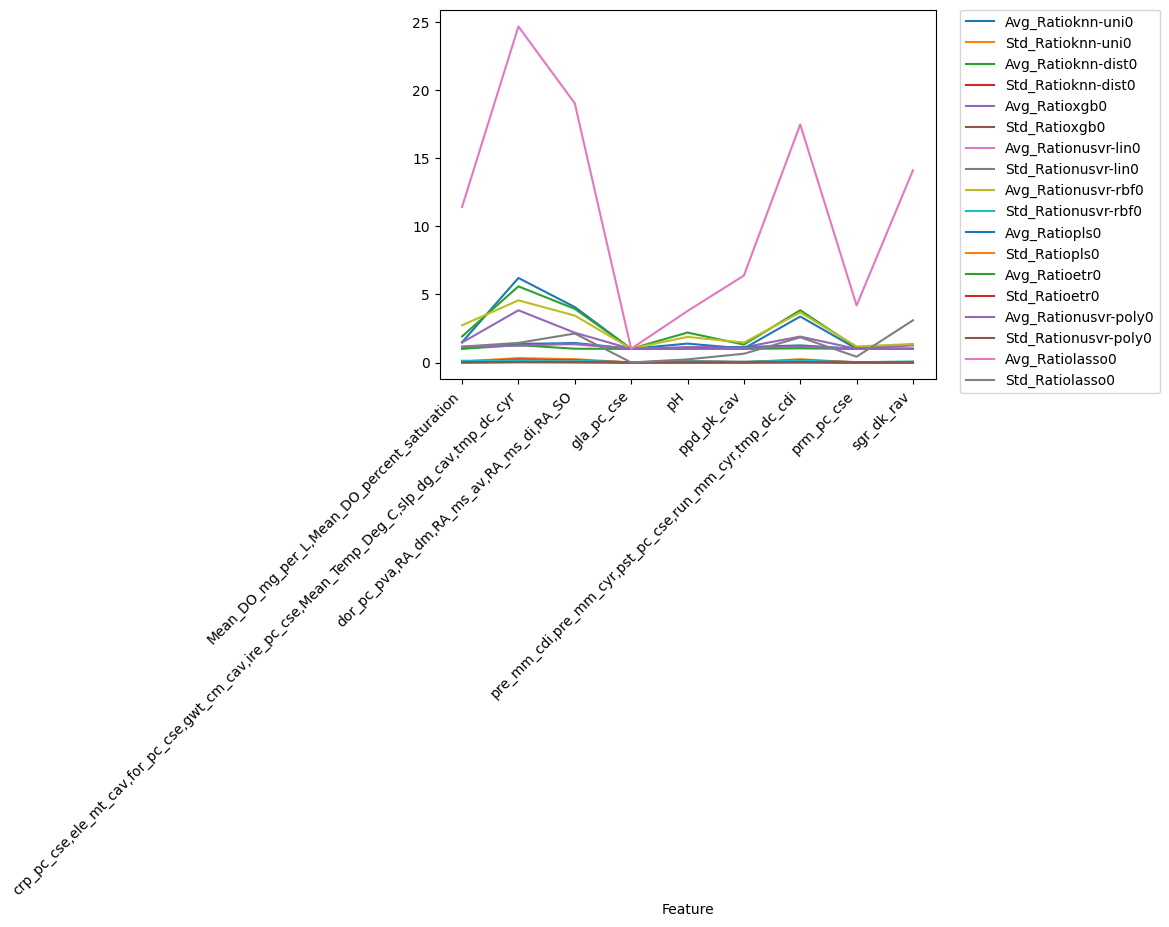

In [4]:
fpi_results.plot()
plt.xticks(rotation=45, ha='right')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.savefig("line_model_fpi_per_variable.png")

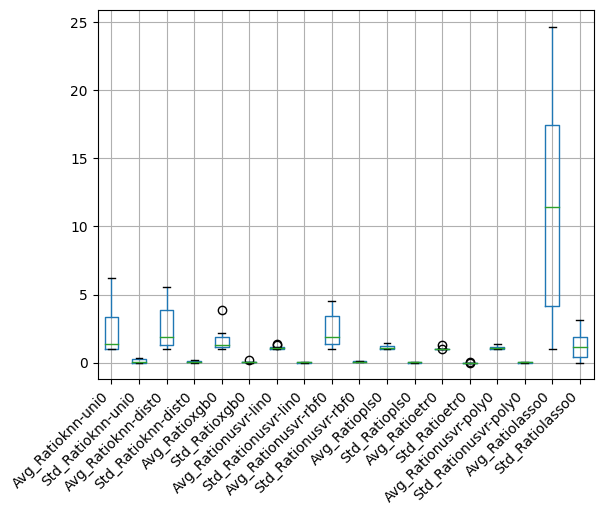

In [5]:
fpi_results.boxplot()
plt.xticks(rotation=45, ha='right')
plt.draw()
plt.savefig("boxplot_variable_fpi_per_model.png")

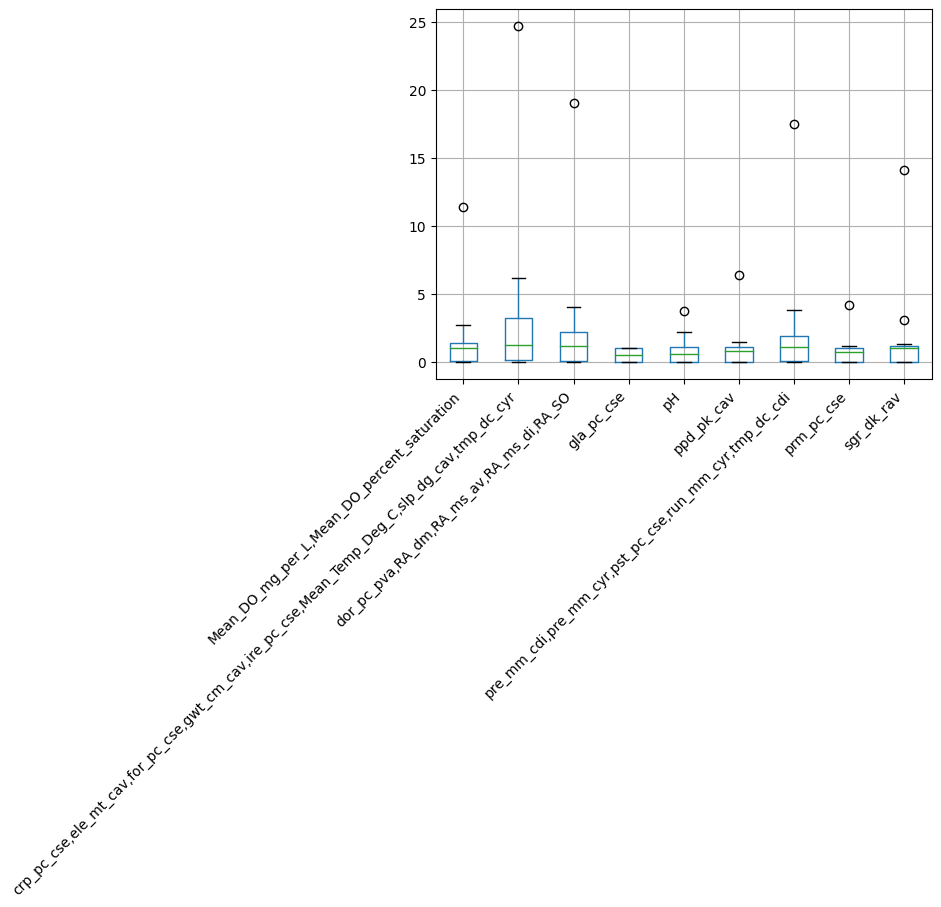

In [6]:
fpi_results.T.boxplot()
plt.xticks(rotation=45, ha='right')
plt.savefig("boxplot_model_fpi_per_variable.png")